In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm  # For progress bar

In [ ]:
# Set parameters
epochs = 50 
batch_size = 64
learning_rate = 5e-5  
dropout_rate = 0.1
noise_factor = 0.05  
patience = 5  

# Load data
nasa_data = pd.read_csv("NASA_labeled.csv")
labels = nasa_data["AnomalyLabel"].values  
features = nasa_data.drop(columns=["AnomalyLabel"]).values  # Remove label column

In [ ]:
# Train-test split with anomaly inclusion
np.random.seed(42)
test_size = 0.2
anomalies = np.where(labels == 1)[0]
normal = np.where(labels == 0)[0]
val_anomalies = np.random.choice(anomalies, size=min(len(anomalies), int(test_size * len(features))), replace=False)
val_normals = np.random.choice(normal, size=int(test_size * len(features)) - len(val_anomalies), replace=False)
val_indices = np.concatenate([val_anomalies, val_normals])
train_indices = np.setdiff1d(np.arange(len(features)), val_indices, assume_unique=True)

train_features = features[train_indices]
val_features = features[val_indices]
train_labels = labels[train_indices]
val_labels = labels[val_indices]

# Convert to tensors
train_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)
val_tensor = torch.tensor(val_features, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# data check
print(f"Train Features: Max {np.max(train_features)}, Min {np.min(train_features)}")
print(f"Validation Features: Max {np.max(val_features)}, Min {np.min(val_features)}")
print(f"Contains NaN: {np.isnan(train_features).any()}")
print(f"Contains Inf: {np.isinf(train_features).any()}")


sequence_length = 512  
train_features_expanded = np.repeat(train_features[:, np.newaxis, :], sequence_length, axis=1)
val_features_expanded = np.repeat(val_features[:, np.newaxis, :], sequence_length, axis=1)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_features_expanded, dtype=torch.float32)
val_tensor = torch.tensor(val_features_expanded, dtype=torch.float32)

print(f"Expanded Train Features Shape: {train_tensor.shape}")  
print(f"Expanded Validation Features Shape: {val_tensor.shape}")  


Train Features: Max 9.608256929388531, Min -10.172599244920752
Validation Features: Max 18.48865581191666, Min -16.857897325418794
Contains NaN: False
Contains Inf: False
Expanded Train Features Shape: torch.Size([62976, 512, 10])
Expanded Validation Features Shape: torch.Size([15743, 512, 10])


In [ ]:
# check anomaly ratio 
num_anomalies = (val_labels == 1).sum()
print(f"Validation Set: {num_anomalies}/{len(val_labels)} anomalies ({num_anomalies/len(val_labels):.2%})")

print(f"Train Features Shape: {train_tensor.shape}")
print(f"Validation Features Shape: {val_tensor.shape}")
print("DataLoader for training and validation is ready.")

Validation Set: 788/15743 anomalies (5.01%)
Train Features Shape: torch.Size([62976, 512, 10])
Validation Features Shape: torch.Size([15743, 512, 10])
DataLoader for training and validation is ready.


In [ ]:
# Define trnasformer model
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, dropout_rate):
        super(TransformerAutoencoder, self).__init__()
        adjusted_dim = hidden_dim * num_heads  
        self.input_projection = nn.Linear(input_dim, adjusted_dim)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=adjusted_dim, nhead=num_heads, dropout=dropout_rate, norm_first=True
            ),
            num_layers=num_layers,
        )
        self.decoder = nn.Sequential(
            nn.Linear(adjusted_dim, input_dim * 2),
            nn.ReLU(),
            nn.Linear(input_dim * 2, input_dim),
        )

    def forward(self, x):
        x = self.input_projection(x)
        x = x.unsqueeze(0)  
        x = self.encoder(x)
        x = x.squeeze(0)
        return self.decoder(x)

    
# Initialize model
input_dim = train_features.shape[1]
model = TransformerAutoencoder(input_dim=input_dim, hidden_dim=128, num_heads=4, num_layers=2, dropout_rate=dropout_rate)
model = model.cuda() if torch.cuda.is_available() else model

# Loss, optimizer and scaler
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

c:\Users\Elena\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\Elena\AppData\Local\Temp\ipykernel_3268\3222971321.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Training loop 
best_val_loss = float("inf")
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs = batch[0].cuda() if torch.cuda.is_available() else batch[0]
        noisy_inputs = inputs + noise_factor * torch.randn_like(inputs)  # Add noise
        optimizer.zero_grad()

        with autocast():
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent exploding gradients
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    reconstruction_errors = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].cuda() if torch.cuda.is_available() else batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()
            errors = torch.mean((outputs - inputs) ** 2, dim=1)
            reconstruction_errors.extend(errors.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "Transformer.pth")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stop")
            break

Epoch 1/50:   0%|          | 0/984 [00:00<?, ?it/s]C:\Users\Elena\AppData\Local\Temp\ipykernel_3268\1840819988.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50: 100%|██████████| 984/984 [00:18<00:00, 51.93it/s]


Epoch 1/50, Train Loss: 0.0637, Val Loss: 0.4383


Epoch 2/50: 100%|██████████| 984/984 [00:17<00:00, 54.82it/s]


Epoch 2/50, Train Loss: 0.0083, Val Loss: 0.2905


Epoch 3/50: 100%|██████████| 984/984 [00:17<00:00, 56.15it/s]


Epoch 3/50, Train Loss: 0.0053, Val Loss: 0.2462


Epoch 4/50: 100%|██████████| 984/984 [00:18<00:00, 52.77it/s]


Epoch 4/50, Train Loss: 0.0043, Val Loss: 0.2110


Epoch 5/50: 100%|██████████| 984/984 [00:18<00:00, 52.10it/s]


Epoch 5/50, Train Loss: 0.0038, Val Loss: 0.1980


Epoch 6/50: 100%|██████████| 984/984 [00:18<00:00, 52.35it/s]


Epoch 6/50, Train Loss: 0.0035, Val Loss: 0.1802


Epoch 7/50: 100%|██████████| 984/984 [00:19<00:00, 51.32it/s]


Epoch 7/50, Train Loss: 0.0033, Val Loss: 0.1738


Epoch 8/50: 100%|██████████| 984/984 [00:18<00:00, 51.93it/s]


Epoch 8/50, Train Loss: 0.0032, Val Loss: 0.1689


Epoch 9/50: 100%|██████████| 984/984 [00:18<00:00, 52.67it/s]


Epoch 9/50, Train Loss: 0.0031, Val Loss: 0.1625


Epoch 10/50: 100%|██████████| 984/984 [00:19<00:00, 49.54it/s]


Epoch 10/50, Train Loss: 0.0030, Val Loss: 0.1559


Epoch 11/50: 100%|██████████| 984/984 [00:19<00:00, 51.04it/s]


Epoch 11/50, Train Loss: 0.0029, Val Loss: 0.1486


Epoch 12/50: 100%|██████████| 984/984 [00:18<00:00, 53.30it/s]


Epoch 12/50, Train Loss: 0.0028, Val Loss: 0.1432


Epoch 13/50: 100%|██████████| 984/984 [00:18<00:00, 53.17it/s]


Epoch 13/50, Train Loss: 0.0028, Val Loss: 0.1393


Epoch 14/50: 100%|██████████| 984/984 [00:18<00:00, 53.60it/s]


Epoch 14/50, Train Loss: 0.0027, Val Loss: 0.1357


Epoch 15/50: 100%|██████████| 984/984 [00:19<00:00, 51.67it/s]


Epoch 15/50, Train Loss: 0.0026, Val Loss: 0.1338


Epoch 16/50: 100%|██████████| 984/984 [00:19<00:00, 51.15it/s]


Epoch 16/50, Train Loss: 0.0026, Val Loss: 0.1282


Epoch 17/50: 100%|██████████| 984/984 [00:18<00:00, 53.32it/s]


Epoch 17/50, Train Loss: 0.0026, Val Loss: 0.1238


Epoch 18/50: 100%|██████████| 984/984 [00:18<00:00, 54.10it/s]


Epoch 18/50, Train Loss: 0.0025, Val Loss: 0.1227


Epoch 19/50: 100%|██████████| 984/984 [00:18<00:00, 54.01it/s]


Epoch 19/50, Train Loss: 0.0024, Val Loss: 0.1215


Epoch 20/50: 100%|██████████| 984/984 [00:18<00:00, 53.61it/s]


Epoch 20/50, Train Loss: 0.0024, Val Loss: 0.1187


Epoch 21/50: 100%|██████████| 984/984 [00:18<00:00, 53.66it/s]


Epoch 21/50, Train Loss: 0.0024, Val Loss: 0.1173


Epoch 22/50: 100%|██████████| 984/984 [00:18<00:00, 53.75it/s]


Epoch 22/50, Train Loss: 0.0024, Val Loss: 0.1159


Epoch 23/50: 100%|██████████| 984/984 [00:18<00:00, 53.64it/s]


Epoch 23/50, Train Loss: 0.0023, Val Loss: 0.1126


Epoch 24/50: 100%|██████████| 984/984 [00:18<00:00, 53.96it/s]


Epoch 24/50, Train Loss: 0.0023, Val Loss: 0.1092


Epoch 25/50: 100%|██████████| 984/984 [00:18<00:00, 52.84it/s]


Epoch 25/50, Train Loss: 0.0023, Val Loss: 0.1105


Epoch 26/50: 100%|██████████| 984/984 [00:18<00:00, 52.82it/s]


Epoch 26/50, Train Loss: 0.0023, Val Loss: 0.1096


Epoch 27/50: 100%|██████████| 984/984 [00:19<00:00, 51.05it/s]


Epoch 27/50, Train Loss: 0.0023, Val Loss: 0.1077


Epoch 28/50: 100%|██████████| 984/984 [00:18<00:00, 53.13it/s]


Epoch 28/50, Train Loss: 0.0022, Val Loss: 0.1069


Epoch 29/50: 100%|██████████| 984/984 [00:18<00:00, 53.77it/s]


Epoch 29/50, Train Loss: 0.0022, Val Loss: 0.1059


Epoch 30/50: 100%|██████████| 984/984 [00:18<00:00, 54.03it/s]


Epoch 30/50, Train Loss: 0.0022, Val Loss: 0.1045


Epoch 31/50: 100%|██████████| 984/984 [00:18<00:00, 54.06it/s]


Epoch 31/50, Train Loss: 0.0022, Val Loss: 0.1049


Epoch 32/50: 100%|██████████| 984/984 [00:18<00:00, 53.75it/s]


Epoch 32/50, Train Loss: 0.0022, Val Loss: 0.1044


Epoch 33/50: 100%|██████████| 984/984 [00:18<00:00, 53.59it/s]


Epoch 33/50, Train Loss: 0.0022, Val Loss: 0.1027


Epoch 34/50: 100%|██████████| 984/984 [00:18<00:00, 52.23it/s]


Epoch 34/50, Train Loss: 0.0021, Val Loss: 0.1014


Epoch 35/50: 100%|██████████| 984/984 [00:18<00:00, 52.61it/s]


Epoch 35/50, Train Loss: 0.0022, Val Loss: 0.0990


Epoch 36/50: 100%|██████████| 984/984 [00:18<00:00, 52.30it/s]


Epoch 36/50, Train Loss: 0.0021, Val Loss: 0.0980


Epoch 37/50: 100%|██████████| 984/984 [00:18<00:00, 52.00it/s]


Epoch 37/50, Train Loss: 0.0021, Val Loss: 0.0984


Epoch 38/50: 100%|██████████| 984/984 [00:19<00:00, 51.65it/s]


Epoch 38/50, Train Loss: 0.0021, Val Loss: 0.0970


Epoch 39/50: 100%|██████████| 984/984 [00:18<00:00, 52.91it/s]


Epoch 39/50, Train Loss: 0.0021, Val Loss: 0.0985


Epoch 40/50: 100%|██████████| 984/984 [00:18<00:00, 53.85it/s]


Epoch 40/50, Train Loss: 0.0021, Val Loss: 0.0996


Epoch 41/50: 100%|██████████| 984/984 [00:18<00:00, 53.68it/s]


Epoch 41/50, Train Loss: 0.0021, Val Loss: 0.0977


Epoch 42/50: 100%|██████████| 984/984 [00:18<00:00, 53.72it/s]


Epoch 42/50, Train Loss: 0.0021, Val Loss: 0.0972


Epoch 43/50: 100%|██████████| 984/984 [00:18<00:00, 53.91it/s]


Epoch 43/50, Train Loss: 0.0021, Val Loss: 0.0965


Epoch 44/50: 100%|██████████| 984/984 [00:18<00:00, 53.72it/s]


Epoch 44/50, Train Loss: 0.0021, Val Loss: 0.0955


Epoch 45/50: 100%|██████████| 984/984 [00:18<00:00, 53.63it/s]


Epoch 45/50, Train Loss: 0.0021, Val Loss: 0.0945


Epoch 46/50: 100%|██████████| 984/984 [00:18<00:00, 53.71it/s]


Epoch 46/50, Train Loss: 0.0021, Val Loss: 0.0953


Epoch 47/50: 100%|██████████| 984/984 [00:18<00:00, 53.58it/s]


Epoch 47/50, Train Loss: 0.0020, Val Loss: 0.0926


Epoch 48/50: 100%|██████████| 984/984 [00:18<00:00, 53.40it/s]


Epoch 48/50, Train Loss: 0.0020, Val Loss: 0.0918


Epoch 49/50: 100%|██████████| 984/984 [00:18<00:00, 52.75it/s]


Epoch 49/50, Train Loss: 0.0020, Val Loss: 0.0926


Epoch 50/50: 100%|██████████| 984/984 [00:18<00:00, 53.12it/s]


Epoch 50/50, Train Loss: 0.0020, Val Loss: 0.0935


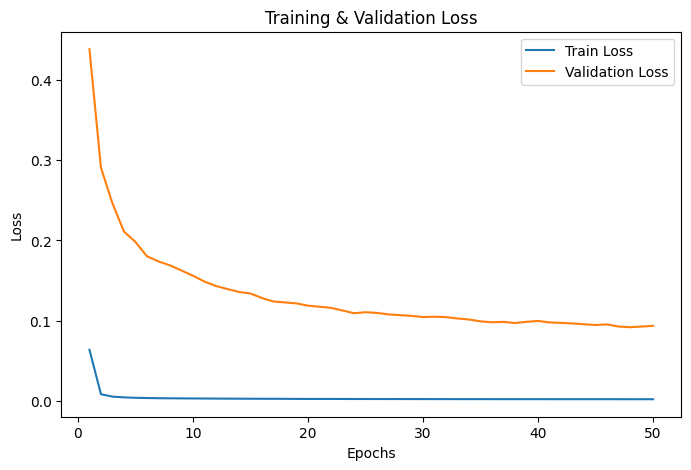

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Perform anomaly detection using reconstruction errors
threshold = np.percentile(reconstruction_errors, 95)  # threshold as the 95th percentile
predicted_labels = (np.array(reconstruction_errors) > threshold).astype(int)

# evaluation metrics 
print("Anomaly Detection Performance:")
print(classification_report(val_labels, predicted_labels, target_names=["Normal", "Anomaly"]))



Anomaly Detection Performance:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     14955
     Anomaly       0.97      0.97      0.97       788

    accuracy                           1.00     15743
   macro avg       0.99      0.99      0.99     15743
weighted avg       1.00      1.00      1.00     15743

